# Parameters
### Stock Parameters
1. $\sigma$ — volatility: estimate using rolling window returns standard deviation (choose step and window size)
### Objective Parameters
1. $\gamma$ — risk-aversion: TODO: look at interpretation
### Market Orders Parameters
1. $\alpha$ — market order size: estimate using rolling window mean with correction for current time average order size (choose the method for correction for time of the day)
1. $\beta$ — market impact
1. $\Lambda$ — trading intensity scale: estimate using exponential distribution between orders for current time (choose the method for correction of intensity for time of the day) 

# Dynamics:
## Stock
$$dS = \sigma dW$$

## Market Orders

### Poisson process

We place orders on $p^b = s - \delta^b$ and $p^a = s + \delta^a$.

Buy orders: Poisson rate $\lambda^a(\delta^a)$
(те расстояние между соседними ордерами распределенно экспоненциально, $\lambda^a$ - насколько далеко мы стоим от справедливой цены)

Sell orders: Poisson rate $\lambda^b(\delta^b)$

$\lambda^{a, b}(\delta)$ — a decreasing function of $\delta$ (the worse the prices the fewer transactions)
(является убыающей по $\delta$)

### Trading intensity: lambda(delta)

The density of market order size: \
Надо вытащить trading intensity, в статье предполагаем, что есть плотность market order size. Далее на практике нужно вытащить распределние объъема рыночного из данных по сделкам. Также посчитать market impact в зависимости от объема ордера. Это можно вытащить из того сколько уровней пробивает один ордер фиксированного размера, либо посмотреть на ордер бук в какой то момент времени и посчитать сколько объема стоит до определнного уровня. Здесь $\Lambda$ - время между ордерами. 
$$f^{Q}(x) \propto \alpha x^{-1 - \alpha}$$
$\alpha = 1.53, 1.4, 1.5$

Market impact:
$$\Delta p \propto Q^{\beta}$$
$\beta = 0.5, 0.76$
$$\Delta p \propto \ln(Q)$$

Trading intensity:
$$\lambda(\delta) = \Lambda P(\Delta p > \delta) = \Lambda P(\ln(Q) > K \delta) = \Lambda P(Q > \exp(K \delta)) = \Lambda \int\limits_{\exp(K\delta)}^{+\infty} \alpha x^{-1 - \alpha} dx = \Lambda e^{\alpha K \delta} = \Lambda e^{-k \delta}$$
where $k = \alpha K$.

In case of $\Delta p \propto Q^{\beta}$:
$$\lambda(\delta) = \Lambda \int\limits_{(K\delta)^{\frac{1}{\beta}}}^{+\infty} \alpha x^{-1 - \alpha} dx = \Lambda K^{-\frac{\alpha}{\beta}} \delta^{-\frac{\alpha}{\beta}}$$

Alternatively. market impact function $\Delta p (Q)$ can be derived directly by integrating the density of the limit order book.
$dN_t^a$ - количество исполненых ордеров до момента t

## Capital
В начальный момент времени не имеем ни капитала ни активов.
Number of dollars held:
$$dX_t = p^a dN_t^a - p^b dN_t^b$$
Number of stocks held:
$$q_t = N_t^b - N_t^a$$

# Objective:
Хотим максимизировать функцию полезности(капитал)
$$v(x, s, q, t) = \mathbb{E}_t[-\exp(-\gamma(x + q S_T)] = -\exp(-\gamma x) \cdot \exp(-\gamma q s) \cdot \exp\left(\frac{\gamma^2 q^2 \sigma^2 (T - t)}{2}\right)$$
1. $x$ — initial wealth in dollars
1. $S_t = s$ — initial stock price
1. $q$ — number of stocks at terminal time $T$
1. $t$ — start time
1. $S_T$ - terminal stock price

### Infinite horizon:
$$\bar v(x, s, q) = \mathbb{E}\left[\int\limits_{0}^{+\infty} -\exp(-wt)\exp(-\gamma(x + q S_t)) dt\right]$$

# Solution:

## Reservation bid/ask prices
$r^b$ and $r^a$ — the prices at which the agent is indifferent between buying/selling 1 security:
$$v(x - r^b(s, q, t), s, q + 1, t) = v(x, s, q, t)$$
$$v(x + r^a(s, q, t), s, q - 1, t) = v(x, s, q, t)$$
Closed form solution:
$$r^a(s, q, t) = s + (1 - 2q)\frac{\gamma \sigma^2 (T - t)}{2}$$
$$r^b(s, q, t) = s + (-1 - 2q)\frac{\gamma \sigma^2 (T - t)}{2}$$
$$r^{a, b}(s, q, t) = s - 2q \frac{\gamma \sigma^2 (T - t)}{2} \pm \frac{\gamma \sigma^2 (T - t)}{2}$$

## Reservation (indifference) price
The average of reservation bid/ask prices:
$$r(s, q, t) = s - q \gamma \sigma^2 (T - t)$$


## (optional) Infinite horizon reservation price
$$\bar r^a(s, q) = s + \frac{1}{\gamma} \ln\left(1 + \frac{(1 - 2q) \gamma^2 \sigma^2}{2w - \gamma^2 q^2 \sigma^2}\right)$$
$$\bar r^b(s, q) = s + \frac{1}{\gamma} \ln\left(1 + \frac{(-1 - 2q) \gamma^2 \sigma^2}{2w - \gamma^2 q^2 \sigma^2}\right)$$
where $w > \frac{1}{2} \gamma^2 \sigma^2 q^2$

$w$ reflects the upper bound on $q$, so we can choose:
$$w = \frac{1}{2} \gamma^2 \sigma^2 (q_{max} + 1)^2$$
This means that:
$$q = q_{max} \Rightarrow r^b = -\infty,\, r^a = s + \frac{1}{\gamma} \ln \frac{2}{1 + 2q_{max}}$$
$$q = -q_{max} \Rightarrow r^a = +\infty,\, r^b = s + \frac{1}{\gamma} \ln \left(2 - \frac{2}{1 + 2q_{max}}\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
import typing as tp
from dataclasses import dataclass


@dataclass
class SimulationsResult:
    q: list[int]
    X: list[float]
    delta_a: list[float]
    delta_b: list[float]
    intensity_a: list[float]
    intensity_b: list[float]


class StoikovModel:
    def __init__(
        self,
            dt: float, T: float,
            S_0: float, sigma: float,
            lambda_intensity_function: tp.Callable[[float], float],  # delta -> intensity
            seed: int = 1
    ) -> None:
        np.random.seed(seed)
        self.dt = dt
        self.T = T
        self.n = round(T / dt)
        self.t = np.arange(0, self.T + self.dt, self.dt)

        self.S_0 = S_0
        self.sigma = sigma

        self.lambda_intensity_function = lambda_intensity_function

        # Calculate S
        self.S = self._get_s()

    def _get_s(self):
        # dS = sigma dW
        dW = np.sqrt(self.dt) * np.random.randn(self.n)   # N(0, dt)
        S = self.S_0 * self.sigma * np.hstack(([0], np.cumsum(dW)))
        return S

    def simulate(self, delta_a_func: tp.Callable[[float, int], float], delta_b_func: tp.Callable, seed: int = 1) -> SimulationsResult:
        np.random.seed(seed)
        X = [0]
        q = [0]
        delta_a_values = []
        delta_b_values = []
        intensity_a_values = []
        intensity_b_values = []
        for i in range(self.n):
            S = self.S[i]
            orders_a, delta_a, intensity_a = self._get_n_orders_executed(delta_a_func, S, q[-1])
            orders_b, delta_b, intensity_b = self._get_n_orders_executed(delta_b_func, S, q[-1])
            q.append(q[-1] + orders_b - orders_a)
            X.append(X[-1] - orders_b * (S - delta_b) + orders_a * (S + delta_a))
            delta_a_values.append(delta_a)
            delta_b_values.append(delta_b)
            intensity_a_values.append(intensity_a)
            intensity_b_values.append(intensity_b)
        return SimulationsResult(
            X=np.array(X),
            q=np.array(q),
            delta_a=np.array(delta_a_values),
            delta_b=np.array(delta_b_values),
            intensity_a=np.array(intensity_a_values),
            intensity_b=np.array(intensity_b_values),
        )

    def _get_n_orders_executed(self, delta_function: tp.Callable[[float, float], float], S, q):
        delta = delta_function(S, q)
        lambda_intensity = self.lambda_intensity_function(delta)
        n_orders = self._poisson_process(lambda_intensity)
        return n_orders, delta, lambda_intensity

    def _poisson_process(self, lambda_intensity: float):
        return np.random.poisson(lam=lambda_intensity * self.dt)

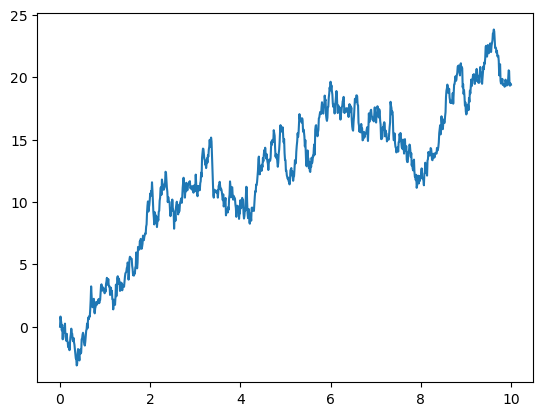

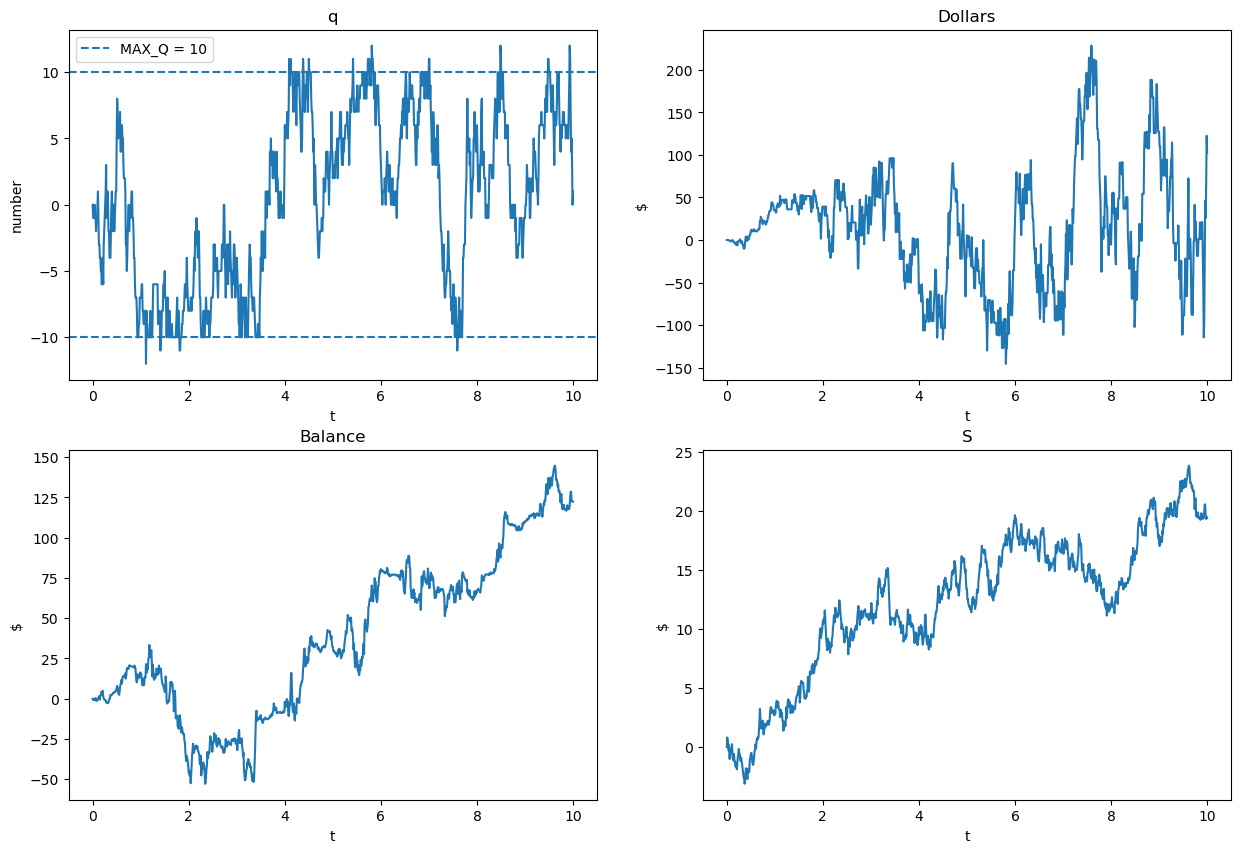

In [50]:
def get_trading_intensity(Lambda: float, k: float) -> tp.Callable[[float], float]:
    return lambda delta: Lambda * np.exp(-k * delta)


model = StoikovModel(
    dt=0.01, T=10,
    S_0=1.0, sigma=5.0,
    lambda_intensity_function=get_trading_intensity(Lambda=100, k=0.001)
)
plt.plot(model.t, model.S)
plt.show()

# можно заменять потом на решение диффура и возвращать нужный спред
def get_delta_function(is_bid: bool, max_q, fixed_spread=0, inf_spread=10000):
    def simple_delta(S, q):
        if is_bid and q >= max_q or not is_bid and q <= -max_q:
            return inf_spread
        return fixed_spread
    return simple_delta


MAX_Q = 10
result = model.simulate(
    delta_a_func=get_delta_function(is_bid=False, max_q=MAX_Q),
    delta_b_func=get_delta_function(is_bid=True, max_q=MAX_Q)
)

plt.subplots(2, 2, figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.t, result.q)
plt.xlabel('t')
plt.title('q')
plt.ylabel('number')
plt.axhline(MAX_Q, linestyle='--', label=f'{MAX_Q = }')
plt.axhline(-MAX_Q, linestyle='--')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model.t, result.X)
plt.xlabel('t')
plt.title('Dollars')
plt.ylabel('$')

plt.subplot(2, 2, 3)
plt.plot(model.t, result.q * model.S + result.X)
plt.xlabel('t')
plt.title('Balance')
plt.ylabel('$')

plt.subplot(2, 2, 4)
plt.plot(model.t, model.S)
plt.xlabel('t')
plt.title('S')
plt.ylabel('$')

plt.show()

In this block I(IVAN) need to get value of parametrs: mid price, sigma, 